# LSST CCOB ghosts showing smart coating

Not that smart really, just considering that the detector reflection coefficient is higher than the ones of lens and filter.


## TODO
- same plot with integrated ghost flux
- update when smart coating will be wavelength dependent

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import compute_ghost_separations
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1



In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


tweak_optics::get_list_of_optics - Ignoring fake baffle
Direct path is number 28
  central impact point is (0.099485, 0.000008)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 677.8413


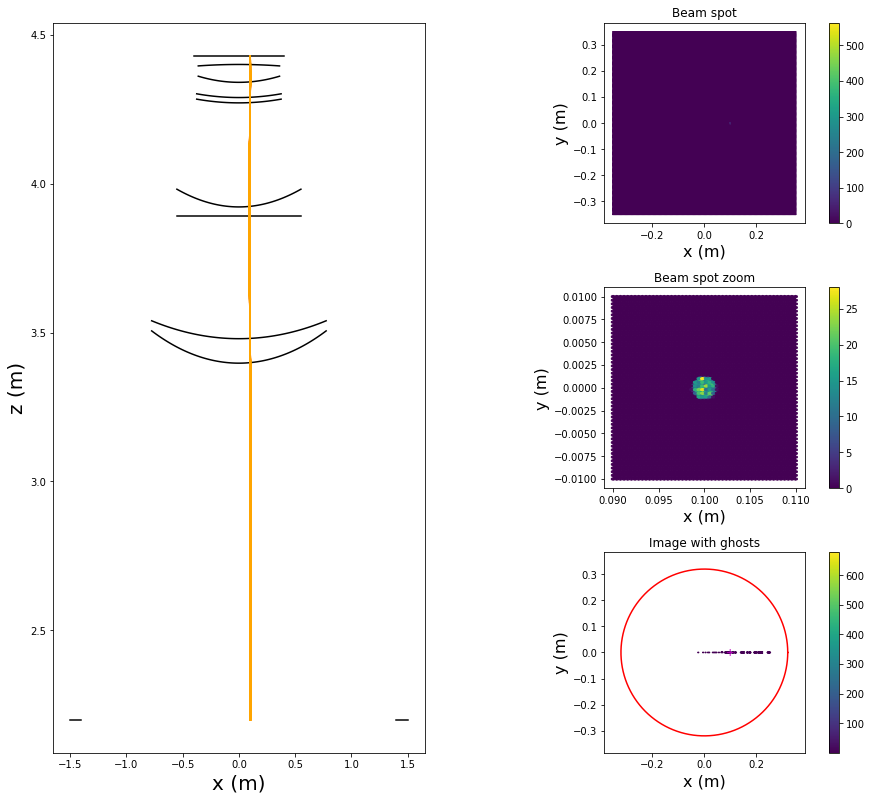

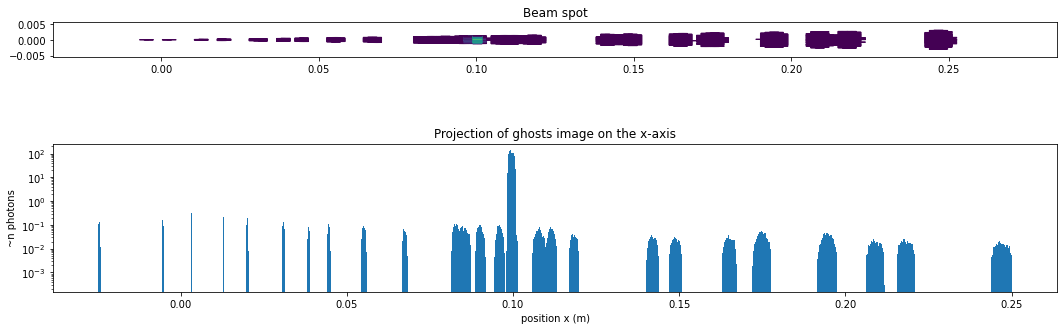

0

In [4]:
# CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

# test list of optics
assert tweak_optics.get_list_of_optics(telescope)==['L1', 'L2', 'Filter', 'L3', 'Detector'], 'Not a CCOB optical setup'

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope)

# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [traceFull, rForward, rReverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


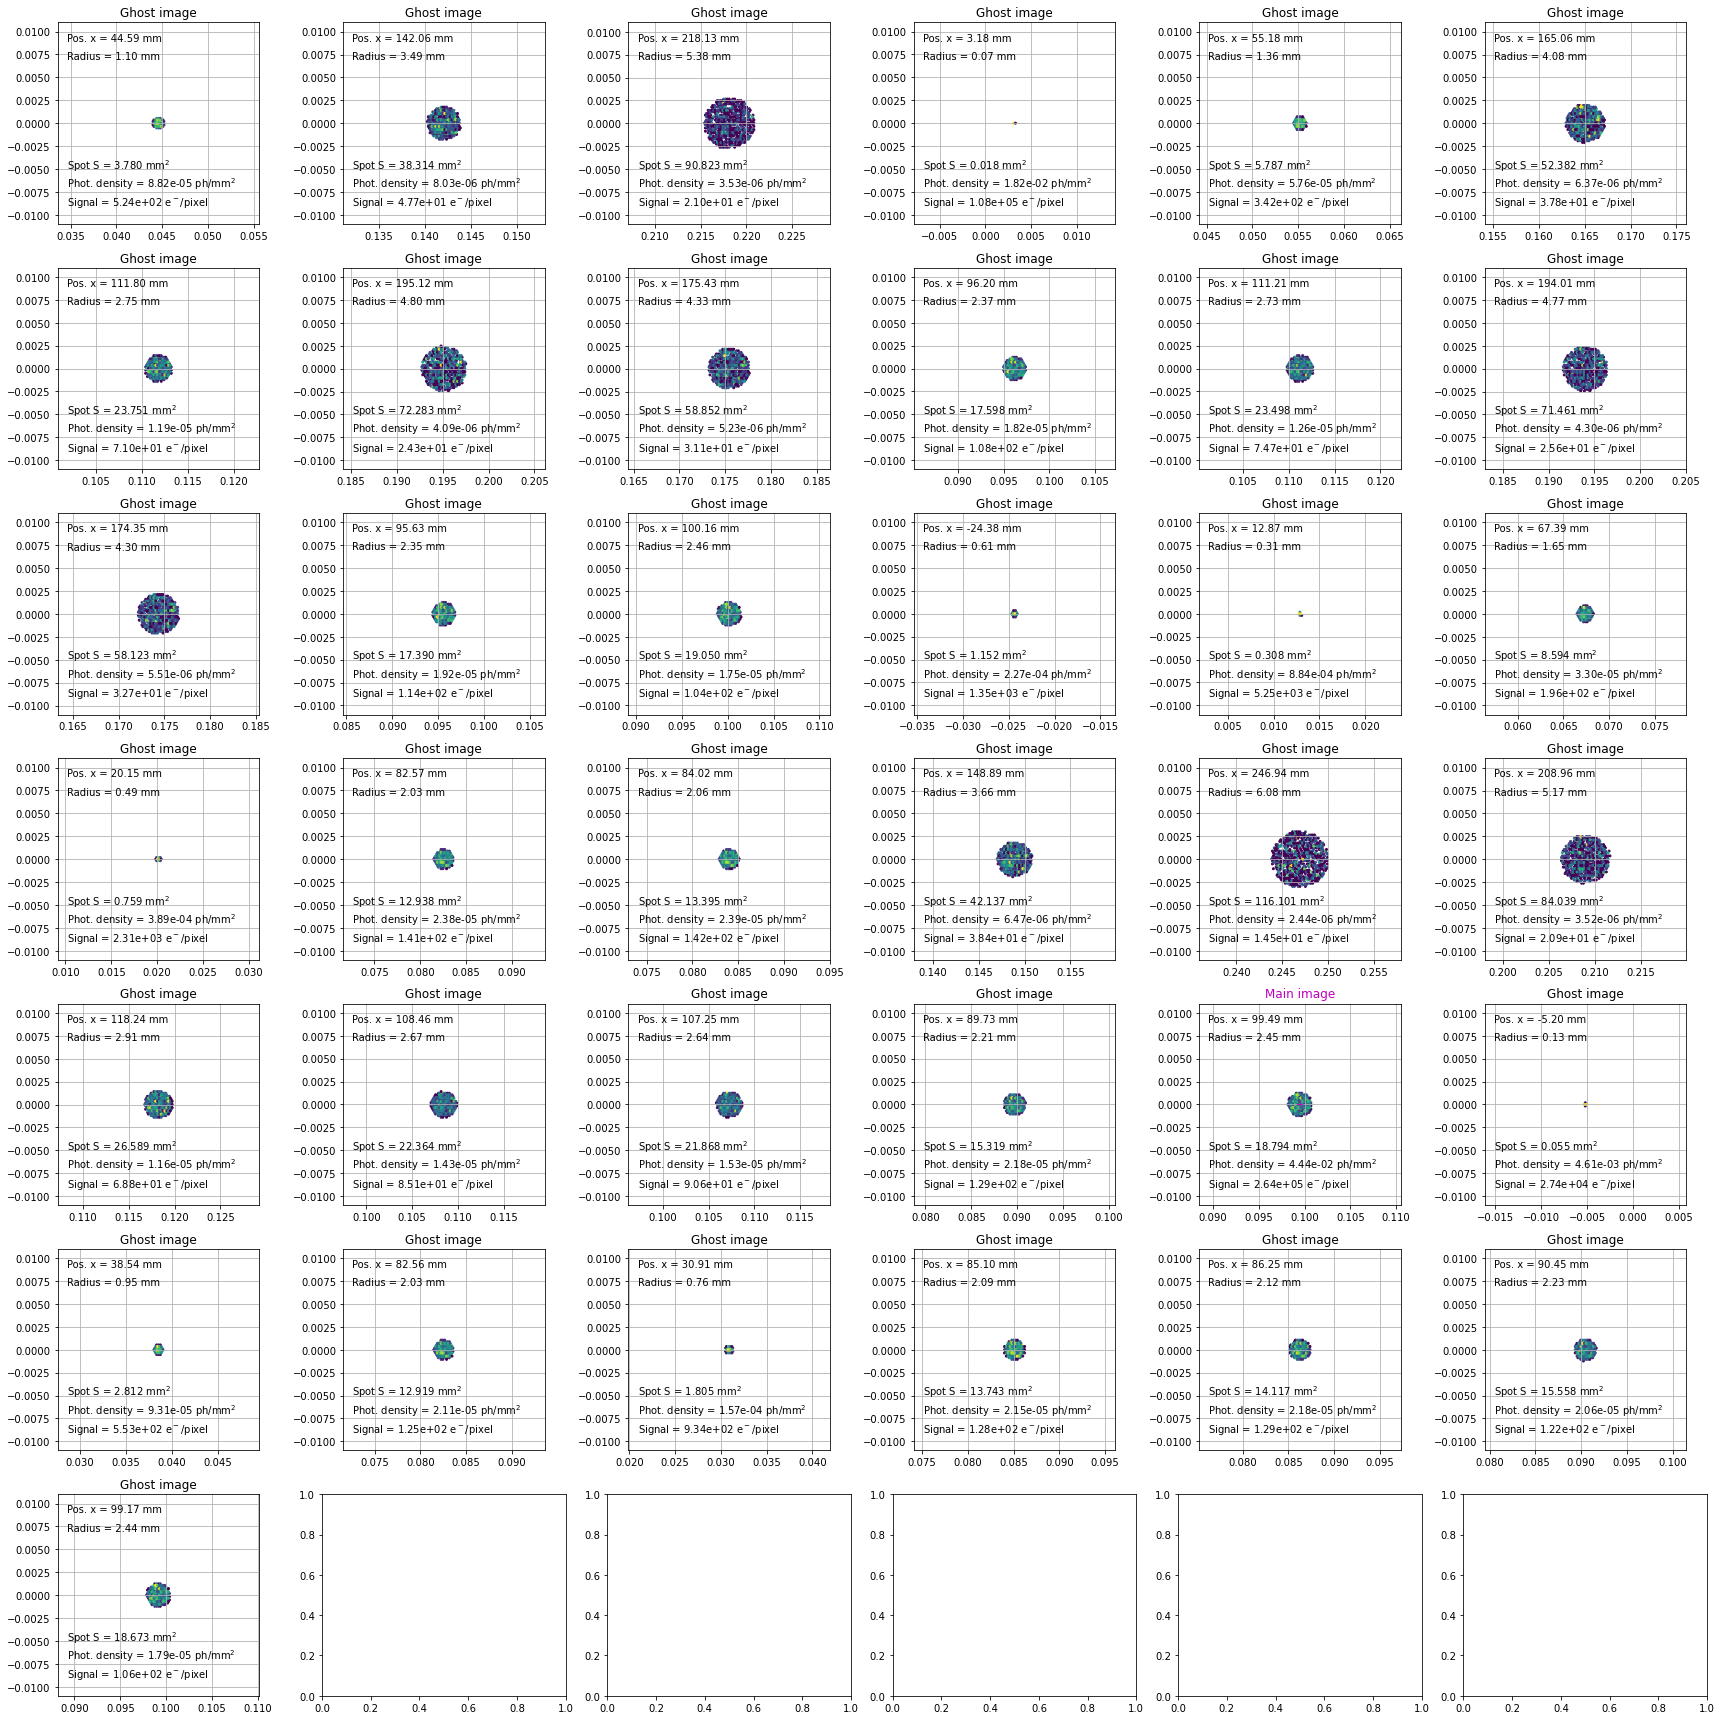

In [5]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data = plotter.plot_ghosts_map(rForward)

Smart coating:  0.02 0.02 0.15
Direct path is number 28
  central impact point is (0.099502, -0.000001)
  transmission is 0.7231

Maximum expected flux is 0.7231
Maximum bin content is 591.9010


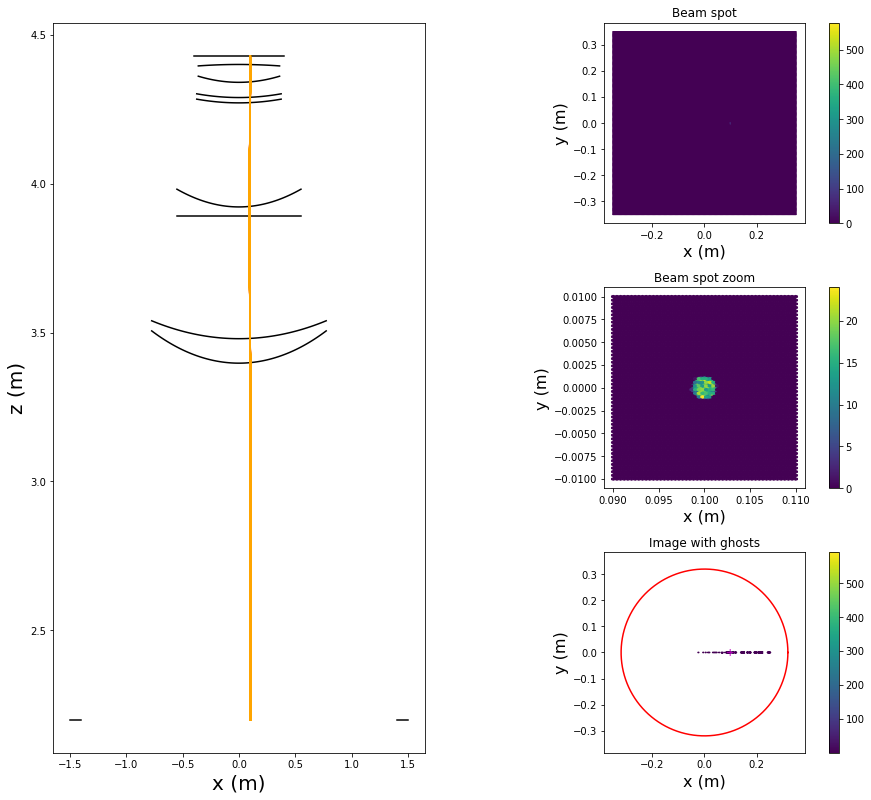

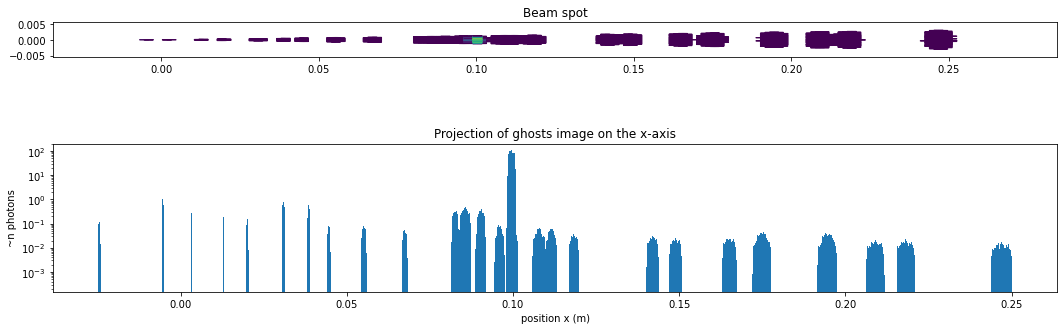

0

In [6]:
# Second simulation with smart coating
# CCOB like geometry, i.e. lenses + filters
telescope_2 = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope_2, coating='smart', r_frac=[0.02, 0.02, 0.15])

# Run simulation with standard beam config
traceFull_2, rForward_2, rReverse_2, rays_2 = simulator.run_simulation(telescope_2, beam_config=BEAM_CONFIG_1)
simulation_2 = [traceFull_2, rForward_2, rReverse_2, rays_2]
# Check setup
plotter.plot_setup(telescope, simulation_2)

# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward_2)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


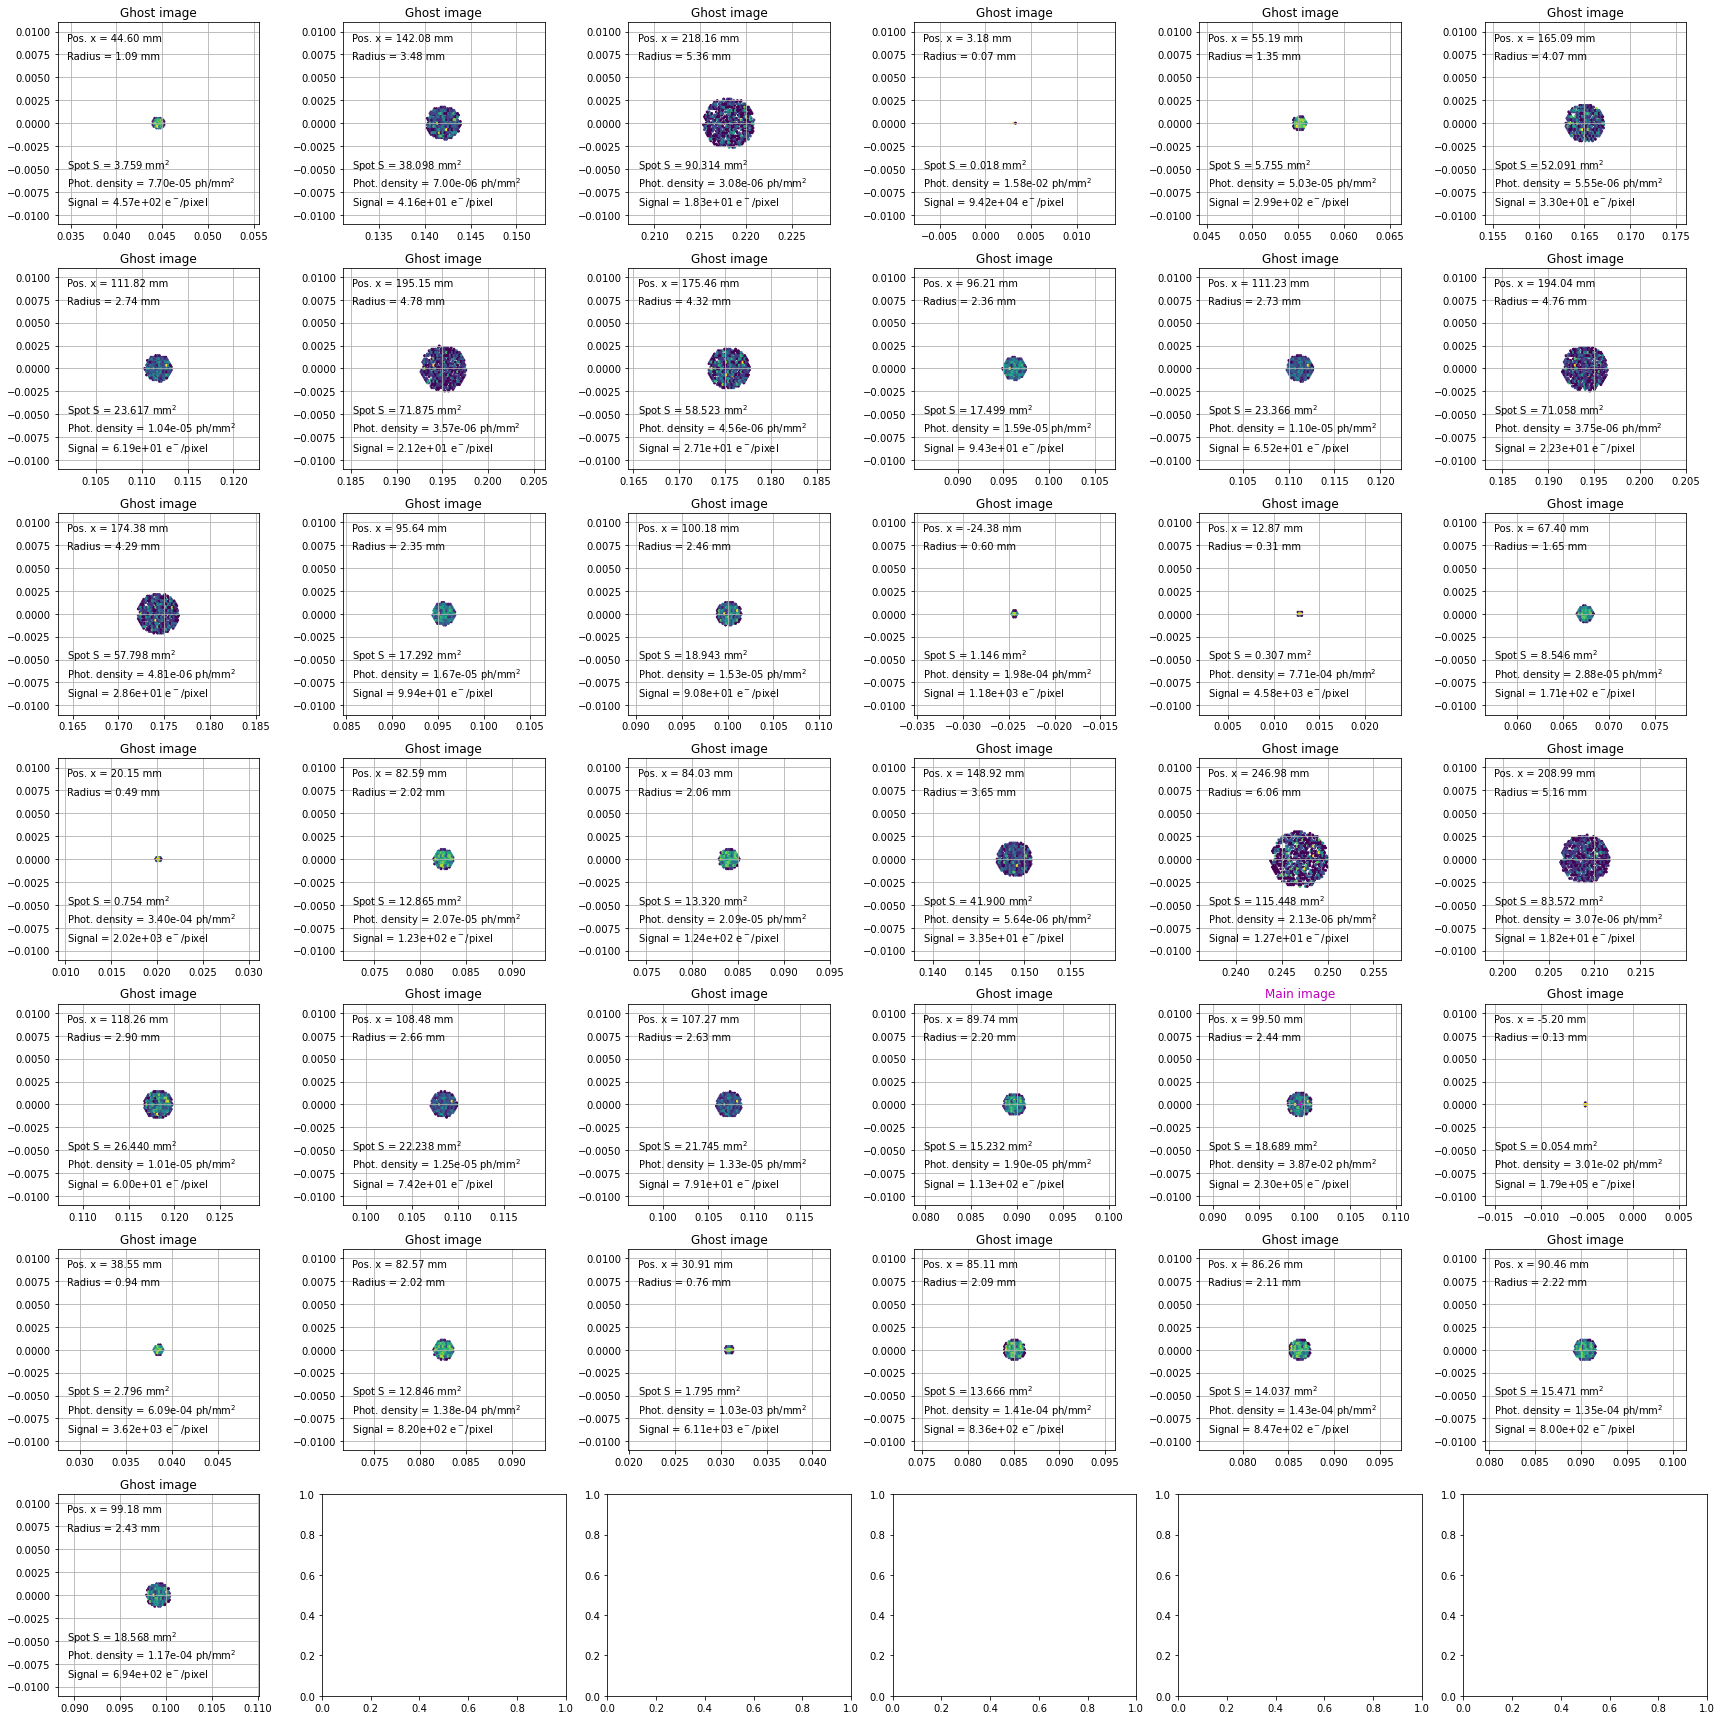

In [7]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data_2 = plotter.plot_ghosts_map(rForward_2)

In [8]:
# analyze spots data
data_frame_1 = make_data_frame(spots_data, BEAM_CONFIG_1['beam_id'])
data_frame_2 = make_data_frame(spots_data_2, BEAM_CONFIG_1['beam_id'])
data_frame_1.head()

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,surface,pixel_signal
0,1,0,0,"(L1_exit, L1_entrance)",0.044594,0.000274,3.638921e-06,0.000274,0.001098,0.001096,0.001097,0.000001,3.780252,524.304594
1,1,0,1,"(L2_exit, L1_entrance)",0.142057,0.000871,1.159206e-05,0.000871,0.003494,0.003491,0.003492,0.000001,38.314283,47.714236
2,1,0,2,"(L2_exit, L1_exit)",0.218128,0.001345,1.779979e-05,0.001345,0.005393,0.005360,0.005377,0.000017,90.822894,20.958548
3,1,0,3,"(L2_entrance, L1_entrance)",0.003179,0.000018,2.593596e-07,0.000018,0.000072,0.000078,0.000075,0.000003,0.017642,107897.150977
4,1,0,4,"(L2_entrance, L1_exit)",0.055182,0.000339,4.502948e-06,0.000339,0.001358,0.001356,0.001357,0.000001,5.787249,342.477648


Text(0.5, 1.0, 'Smart vs simple coating')

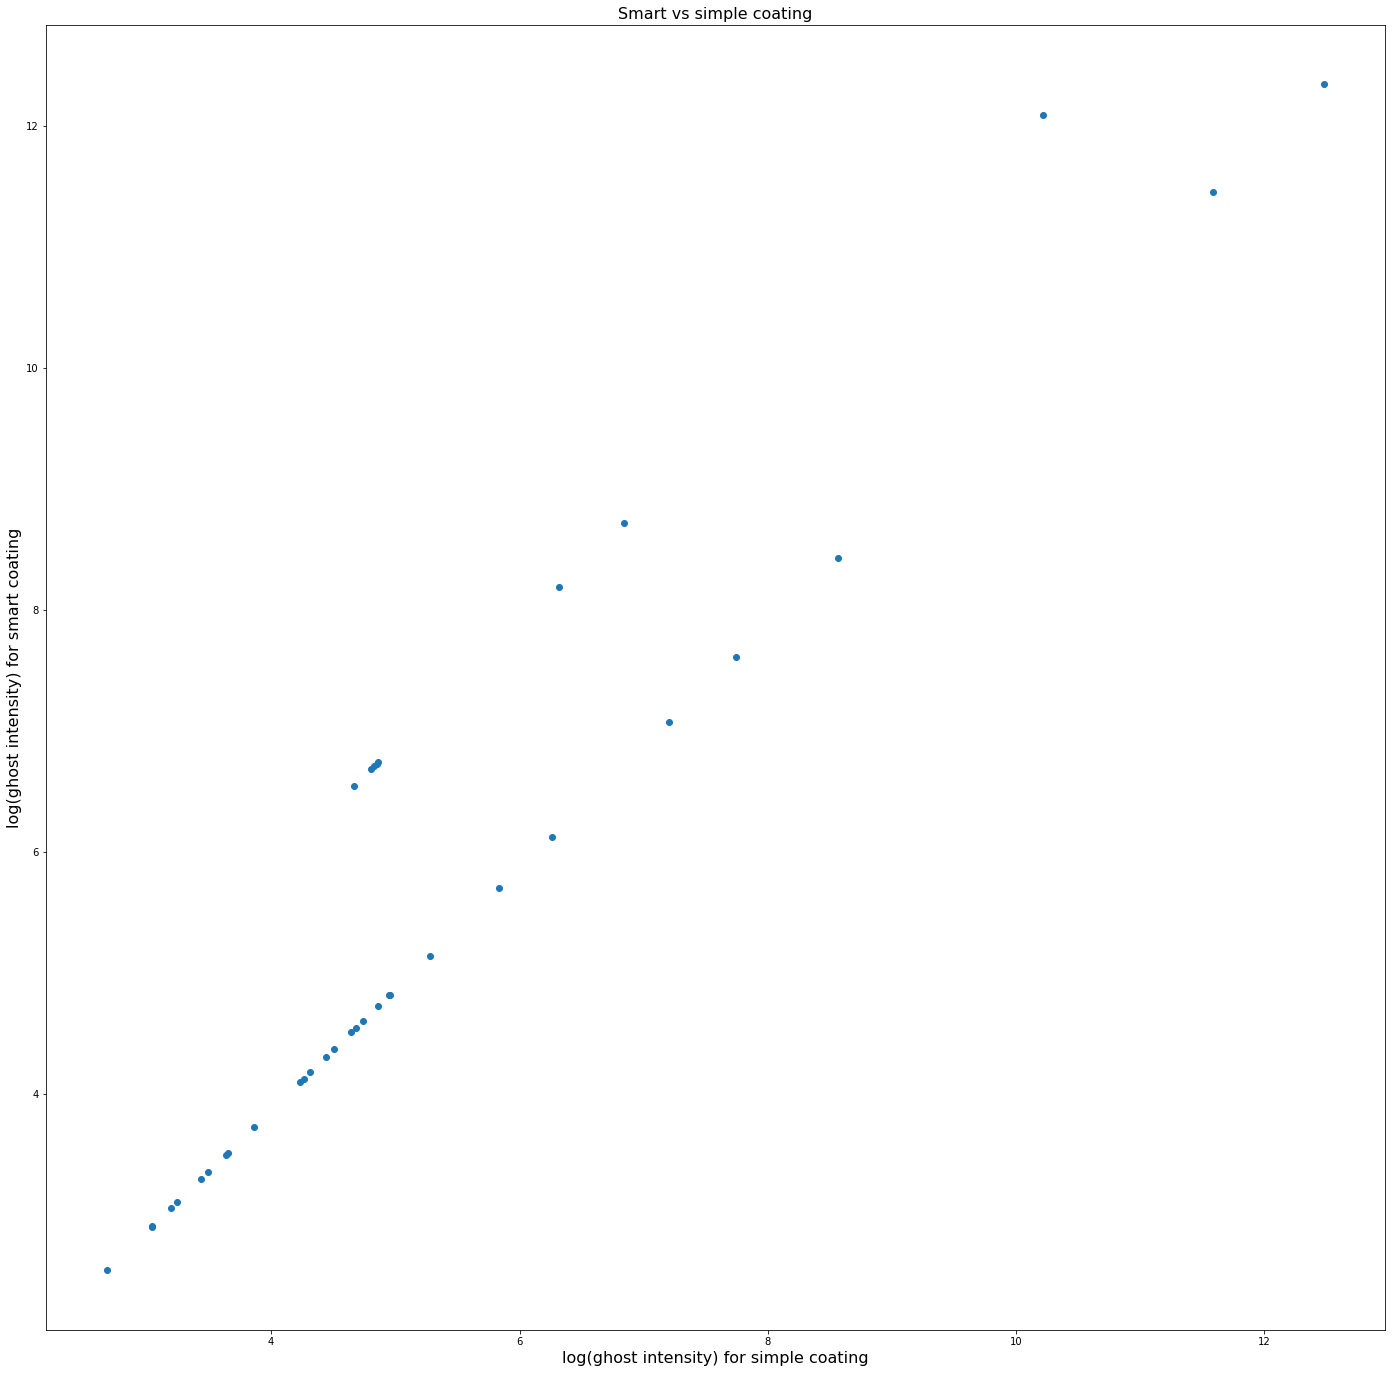

In [9]:
# Plotting ghost signal for simple coating vs smart coating
# ghosts involving the detector have a 7 times larger reflection coefficient for smart coating
plt.scatter(np.log(data_frame_1['pixel_signal']), np.log(data_frame_2['pixel_signal']))
plt.xlabel('log(ghost intensity) for simple coating', fontsize=16)
plt.ylabel('log(ghost intensity) for smart coating', fontsize=16)
plt.title('Smart vs simple coating', fontsize=16)

Text(0.5, 1.0, 'Ratio of ghost signal for smart over simple coating')

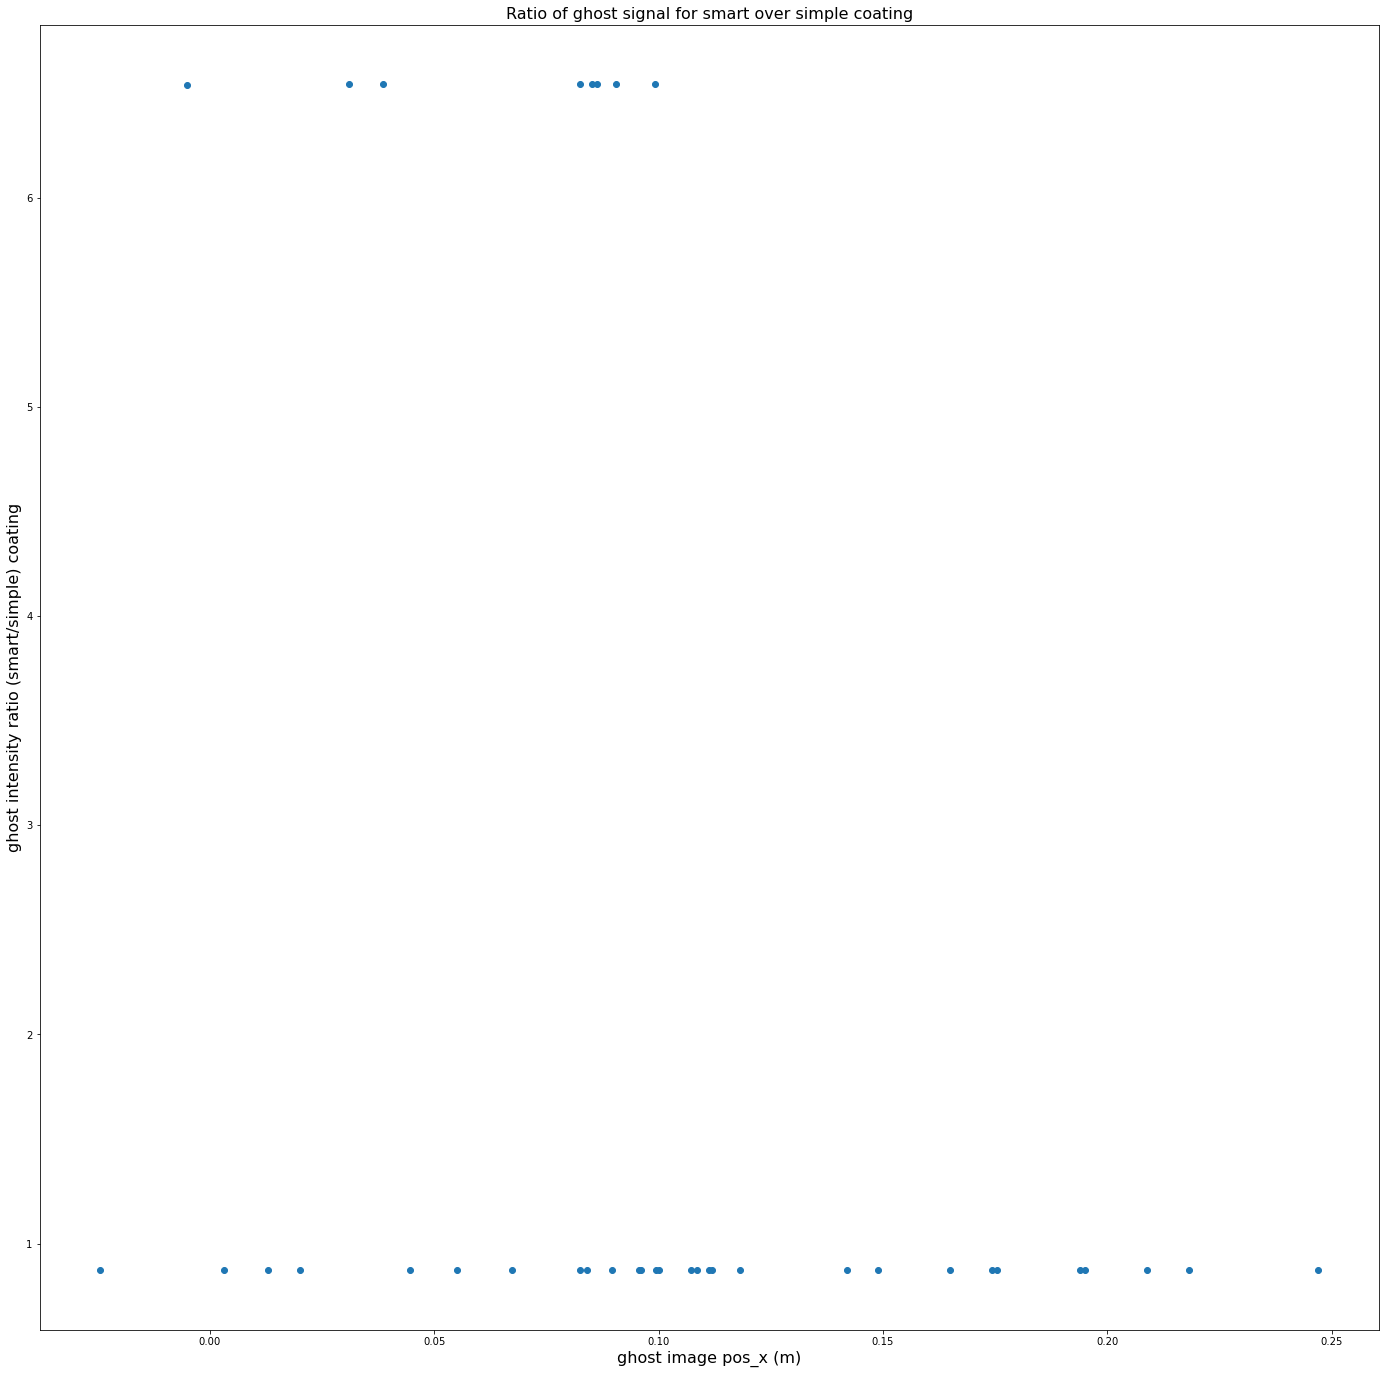

In [10]:
# Plotting ghost signal ratio
# high ratio correspond to ghosts involving the detector that has a 7 times larger reflection coefficient
plt.scatter(data_frame_1['pos_x'], data_frame_2['pixel_signal']/data_frame_1['pixel_signal'])
plt.xlabel('ghost image pos_x (m)', fontsize=16)
plt.ylabel('ghost intensity ratio (smart/simple) coating', fontsize=16)
plt.title('Ratio of ghost signal for smart over simple coating', fontsize=16)